In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'

# 数据预处理部分

In [2]:
train = pd.read_csv('data/card_train.csv')

In [3]:
#特征工程一：统计训练数据的具体信息
train_info = train.info()
print(train_info)
cat_features = list(train.select_dtypes(include=['object']).columns)
print ("离散特征共计: {} 个".format(len(cat_features)))
cont_features = [cont for cont in list(train.select_dtypes(include=['float64', 'int64']).columns) if cont not in [train.columns[-1], train.columns[0]]]
print ("连续特征共计: {}  个".format(len(cont_features)))
id_col = list(train.select_dtypes(include=['int64']).columns)
print ("数据编号特征在第一列是: {}".format(train.columns[0]))
print ("进行预测的因变量特征是: {}".format(train.columns[-1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 31 columns):
Time      99999 non-null int64
V1        99999 non-null float64
V2        99999 non-null float64
V3        99999 non-null float64
V4        99999 non-null float64
V5        99999 non-null float64
V6        99999 non-null float64
V7        99999 non-null float64
V8        99999 non-null float64
V9        99999 non-null float64
V10       99999 non-null float64
V11       99999 non-null float64
V12       99999 non-null float64
V13       99999 non-null float64
V14       99999 non-null float64
V15       99999 non-null float64
V16       99999 non-null float64
V17       99999 non-null float64
V18       99999 non-null float64
V19       99999 non-null float64
V20       99999 non-null float64
V21       99999 non-null float64
V22       99999 non-null float64
V23       99999 non-null float64
V24       99999 non-null float64
V25       99999 non-null float64
V26       99999 non-null float64
V2

In [4]:
#特征工程二：按照比例删除缺失数据
isnull_columns = []
isnull_percent = 0.4
for i in train.columns:
    isnull_col_percent = len(train[i][pd.isnull(train[i])])/len(train)
    if isnull_col_percent >= isnull_percent:
        isnull_columns.append(i)
train = train.drop(isnull_columns,axis=1)

In [5]:
#特征工程三：填充缺失数据，离散特征填充众数，连续特征填充均值或者中位数
cat_fuction = ""
cont_fuction = ""
cat_features = list(train.select_dtypes(include=['object']).columns)
print ("最终确定离散特征共计: {} 个".format(len(cat_features)))
cont_features = [cont for cont in list(train.select_dtypes(include=['float64', 'int64']).columns) if cont not in [train.columns[-1], train.columns[0]]]
print ("最终确定连续特征共计: {}  个".format(len(cont_features)))
id_col = list(train.select_dtypes(include=['int64']).columns)

if cat_fuction == "众数":
    train[cat_features] = train[cat_features].fillna(train[cat_features].mode())
else:  
    train[cat_features] = train[cat_features].fillna(cat_fuction)
if cont_fuction == "均值":
    train[cont_features] = train[cont_features].fillna(train[cont_features].mean())
if cont_fuction == "众数":
    train[cont_features] = train[cont_features].fillna(train[cont_features].mode())
else:
    train[cat_features] = train[cat_features].fillna("0")

最终确定离散特征共计: 0 个
最终确定连续特征共计: 29  个


In [6]:
#特征工程四：数据标准化或者归一化处理
data_processing = ""
x = train[cont_features]
if cont_fuction == "归一化":
    minMax = MinMaxScaler()
    train[cont_features] = minMax.fit_transform(x)
elif cont_fuction == "标准化":
    std = StandardScaler()
    train[cont_features] = std.fit_transform(x)
else:
    pass

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000204896660F0>,
      dtype=object)

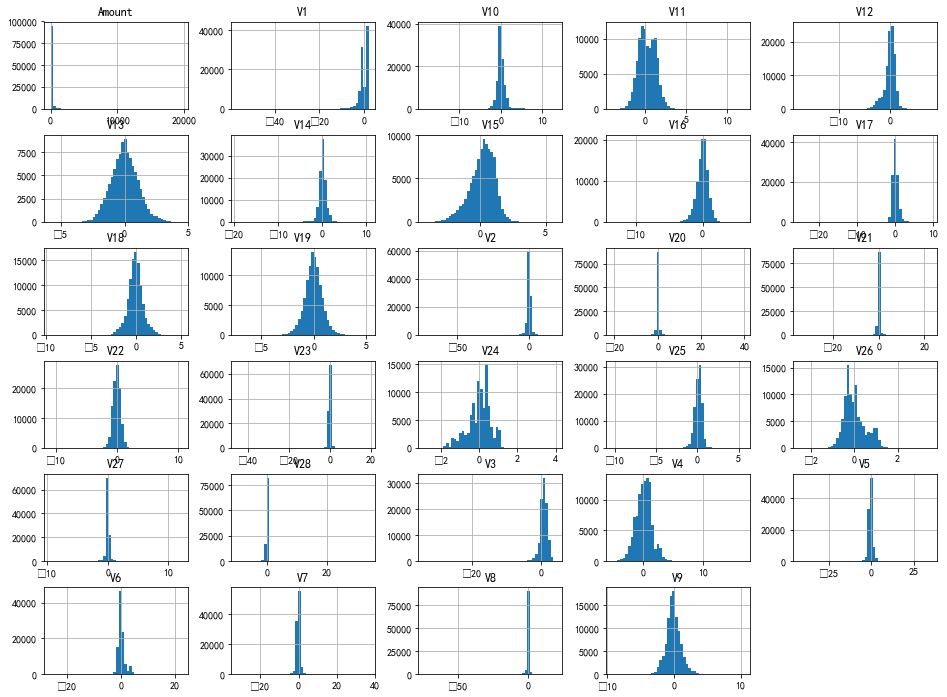

In [7]:
# 特征工程五：整理观测连续变量
cont_features_list = []
for i in cont_features:
    cont_features_list.append ((i,str(stats.mstats.skew(train[cont_features][i]).data)))
cont_features_list = pd.DataFrame(cont_features_list,columns=["变量","峰值"])
cont_features_list_json = cont_features_list.to_json()
train[cont_features].hist(bins=50, figsize=(16,12))

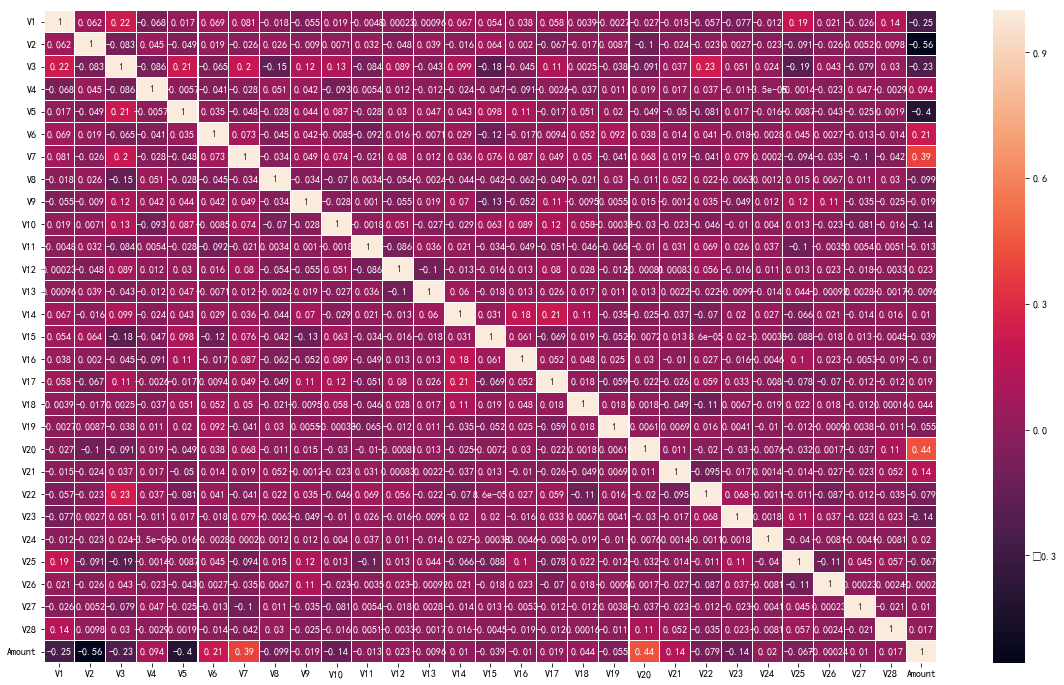

In [8]:
#特征工程六：观测连续变量相关性
plt.subplots(figsize=(20,12))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True,linewidths = 0.05,annot_kws={'size':10,'weight':'bold'})

# 模型调参与调参可视化

In [9]:
all_features = [x for x in train.columns if x not in [train.columns[0],train.columns[-1]]]
#划分自变量和因变量
train_x = train[all_features]
train_y = train[train.columns[-1]]
#将离散数据转换成哑变量
for i in range(len(cat_features)):
    train_x[cat_features[i]] = train_x[cat_features[i]].astype('category').cat.codes

In [10]:
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost as xgb
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import pylab
pylab.mpl.rcParams['font.sans-serif'] = ['STSONG']#防止中文乱码
pylab.mpl.rcParams['axes.unicode_minus'] = False#防止中文乱码

In [11]:
cv_num = 5
verbose = 1
n_jobs = 8
scoring_fuction = 'accuracy'

### scoring_fuction 方法汇总
|	Scoring	|	Function	|	Comment	|
|	:-:	|	:-:	|	:-:	|
|	Classification	|
|	‘accuracy’	|	metrics.accuracy_score	|		|
|	‘balanced_accuracy’	|	metrics.balanced_accuracy_score	|	for binary targets	|
|	‘average_precision’	|	metrics.average_precision_score	|		|
|	‘brier_score_loss’	|	metrics.brier_score_loss	|		|
|	‘f1’	|	metrics.f1_score	|	for binary targets	|
|	‘f1_micro’	|	metrics.f1_score	|	micro-averaged	|
|	‘f1_macro’	|	metrics.f1_score	|	macro-averaged	|
|	‘f1_weighted’	|	metrics.f1_score	|	weighted average	|
|	‘f1_samples’	|	metrics.f1_score	|	by multilabel sample	|
|	‘neg_log_loss’	|	metrics.log_loss	|	requires predict_proba support	|
|	‘precision’ etc.	|	metrics.precision_score	|	suffixes apply as with ‘f1’	|
|	‘recall’ etc.	|	metrics.recall_score	|	suffixes apply as with ‘f1’	|
|	‘roc_auc’	|	metrics.roc_auc_score	|		|
|	Clustering	|
|	‘adjusted_mutual_info_score’	|	metrics.adjusted_mutual_info_score	|		|
|	‘adjusted_rand_score’	|	metrics.adjusted_rand_score	|		|
|	‘completeness_score’	|	metrics.completeness_score	|		|
|	‘fowlkes_mallows_score’	|	metrics.fowlkes_mallows_score	|		|
|	‘homogeneity_score’	|	metrics.homogeneity_score	|		|
|	‘mutual_info_score’	|	metrics.mutual_info_score	|		|
|	‘normalized_mutual_info_score’	|	metrics.normalized_mutual_info_score	|		|
|	‘v_measure_score’	|	metrics.v_measure_score	|		|
|	Regression	|
|	‘explained_variance’	|	metrics.explained_variance_score	|		|
|	‘neg_mean_absolute_error’	|	metrics.mean_absolute_error	|		|
|	‘neg_mean_squared_error’	|	metrics.mean_squared_error	|		|
|	‘neg_mean_squared_log_error’	|	metrics.mean_squared_log_error	|		|
|	‘neg_median_absolute_error’	|	metrics.median_absolute_error	|		|
|	‘r2’	|	metrics.r2_score	|		|  


### objective方法汇总
|	Function	|	Comment	|
|	:-:	|	:-:	|
|reg:linear |linear regression|
|reg:logistic |logistic regression|
|binary:logistic |logistic regression for binary classification, output probability|
|binary:logitraw |logistic regression for binary classification, output score before logistic transformation|
|binary:hinge |hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.count:poisson –poisson regression for count data, output mean of poisson distribution max_delta_step is set to 0.7 by default in poisson regression (used to safeguard optimization)|
|survival:cox |Cox regression for right censored survival time data (negative values are considered right censored). Note that predictions are returned on the hazard ratio scale (i.e., as HR = exp(marginal_prediction) in the proportional hazard function h(t) = h0(t) * HR).|
|multi:softmax |set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)|
multi:softprob |same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.|
|rank:pairwise |Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized|
|rank:ndcg |Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized|
|rank:map |Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized|
|reg:gamma |gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.|
|reg:tweedie |Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.|

In [12]:
%%time
#调参过程一：
# max_depth树的最大深度，值越大，树越大，模型越复杂 可以用来防止过拟合
# min_child_weight一个子集的所有观察值的最小权重和。
cv_params = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:logistic'}#业务类型
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, return_train_score=True,verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
max_depth = optimized_GBM.best_params_['max_depth']
min_child_weight = optimized_GBM.best_params_['min_child_weight']

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  3.6min finished


每次运行的结果如下:
 params:{'max_depth': 4, 'min_child_weight': 1}  mean:0.998909989099891   std:0.0009117715236068835   rank:2
 params:{'max_depth': 4, 'min_child_weight': 3}  mean:0.998769987699877   std:0.0010413973888464725   rank:9
 params:{'max_depth': 4, 'min_child_weight': 6}  mean:0.998649986499865   std:0.0013794377338918083   rank:11
 params:{'max_depth': 5, 'min_child_weight': 1}  mean:0.998919989199892   std:0.000845893341385988   rank:1
 params:{'max_depth': 5, 'min_child_weight': 3}  mean:0.998789987899879   std:0.0010854948975047394   rank:8
 params:{'max_depth': 5, 'min_child_weight': 6}  mean:0.998579985799858   std:0.0015167140880454218   rank:12
 params:{'max_depth': 6, 'min_child_weight': 1}  mean:0.998869988699887   std:0.0009146177482804667   rank:3
 params:{'max_depth': 6, 'min_child_weight': 3}  mean:0.998769987699877   std:0.0011231620171513177   rank:9
 params:{'max_depth': 6, 'min_child_weight': 6}  mean:0.998569985699857   std:0.001510106474687551   rank:13
 params

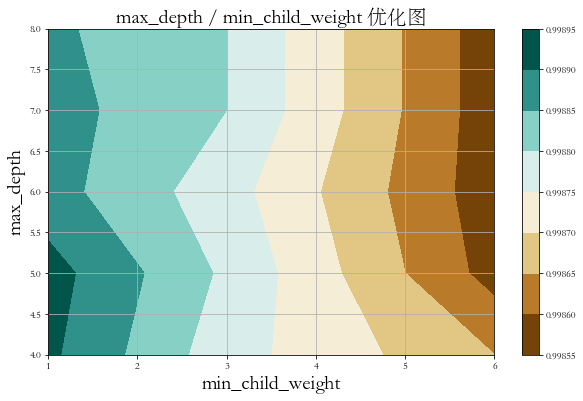

In [13]:
###图表显示参数优化程度
#热力图
# grid_visualization=[]
# for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
#     grid_visualization.append(grid_pair)
# grid_visualization=np.array(grid_visualization)
# grid_visualization.shape=(5, 3)
# sns.heatmap(grid_visualization,annot=True,linewidths = 1,annot_kws={'size':20,'weight':'bold'})
# plt.xticks(np. arange(3)+0.5,optimized_GBM.param_grid['min_child_weight'])
# plt.yticks(np. arange(5)+0.5,optimized_GBM.param_grid['max_depth'])
# plt.xlabel('min_child_weight')
# plt.ylabel('max_depth')
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
scores = grid_visualization.reshape(len(cv_params['max_depth']),len(cv_params['min_child_weight']))
plt.figure(figsize=(10,6))
cp = plt.contourf(cv_params['min_child_weight'],cv_params['max_depth'],scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('max_depth / min_child_weight 优化图',fontsize=20)
plt.xlabel('min_child_weight',fontsize=20)
plt.ylabel('max_depth',fontsize=20)
plt.grid(True)

In [14]:
%%time
# 调参过程二：
# gamma 分裂节点时，损失函数减小值只有大于等于gamma节点才分裂，gamma值越大，算法越保守，越不容易过拟合，但性能就不一定能保证，需要平衡
cv_params = {'gamma':[ 0.1 * i for i in range(0,5)]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:logistic'}#业务类型
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, return_train_score=True,verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
gamma = optimized_GBM.best_params_['gamma']

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   46.5s finished


每次运行的结果如下:
 params:{'gamma': 0.0}  mean:0.998919989199892   std:0.000845893341385988   rank:1
 params:{'gamma': 0.1}  mean:0.998919989199892   std:0.000845893341385988   rank:1
 params:{'gamma': 0.2}  mean:0.998919989199892   std:0.000845893341385988   rank:1
 params:{'gamma': 0.30000000000000004}  mean:0.998919989199892   std:0.000845893341385988   rank:1
 params:{'gamma': 0.4}  mean:0.998919989199892   std:0.000845893341385988   rank:1
---------------------------
参数的最佳取值：{'gamma': 0.0}
最佳模型得分:0.998919989199892
Wall time: 49.7 s


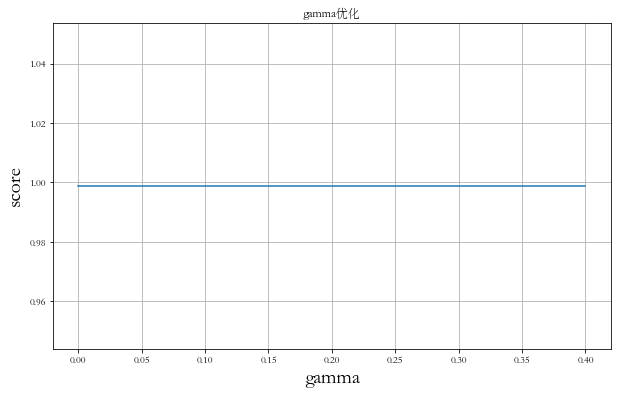

In [15]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
plt.figure(figsize=(10,6))
plt.title('gamma优化')
plt.xlabel('gamma',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot(cv_params['gamma'], grid_visualization)
plt.grid(True)
plt.show()

In [16]:
%%time
#调参过程三：
# subsample 构建每棵树对样本的采样率，如果设置成0.5，XGBoost会随机选择一半的样本作为训练集。
# colsample_bytree 列采样率，也就是特征采样率。
cv_params = {'subsample':[ 0.1 * i for i in range(6,9)],'colsample_bytree':[ 0.1 * i for i in range(6,9)]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': gamma, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:logistic'}#业务类型
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
subsample = optimized_GBM.best_params_['subsample']
colsample_bytree = optimized_GBM.best_params_['colsample_bytree']

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  1.3min finished


每次运行的结果如下:
 params:{'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001}  mean:0.998949989499895   std:0.0007745619908550911   rank:1
 params:{'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001}  mean:0.998939989399894   std:0.000835666171912889   rank:3
 params:{'colsample_bytree': 0.6000000000000001, 'subsample': 0.8}  mean:0.998859988599886   std:0.0009551542711280687   rank:7
 params:{'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001}  mean:0.998919989199892   std:0.0008243412733456399   rank:4
 params:{'colsample_bytree': 0.7000000000000001, 'subsample': 0.7000000000000001}  mean:0.998949989499895   std:0.0008203297250531118   rank:1
 params:{'colsample_bytree': 0.7000000000000001, 'subsample': 0.8}  mean:0.998889988899889   std:0.0008951686971035819   rank:6
 params:{'colsample_bytree': 0.8, 'subsample': 0.6000000000000001}  mean:0.998849988499885   std:0.0009449438256437096   rank:8
 params:{'colsample_bytree': 0.8, 

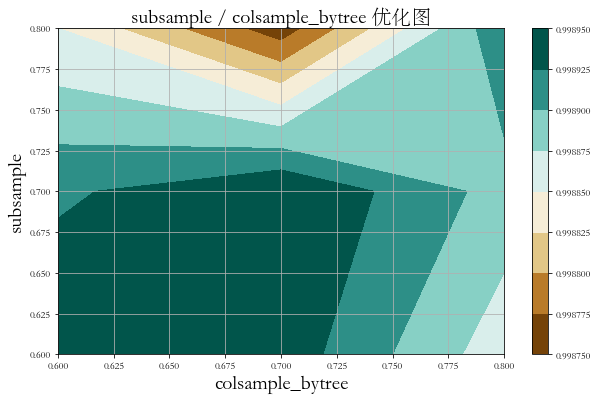

In [17]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
scores = grid_visualization.reshape(len(cv_params['subsample']),len(cv_params['colsample_bytree']))
plt.figure(figsize=(10,6))
cp = plt.contourf(cv_params['colsample_bytree'],cv_params['subsample'],scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('subsample / colsample_bytree 优化图',fontsize=20)
plt.xlabel('colsample_bytree',fontsize=20)
plt.ylabel('subsample',fontsize=20)
plt.grid(True)

In [18]:
%%time
# 调参过程四：
# reg_alpha L1正则化，增加该值会让模型更加收敛
# reg_lambda L2正则化，这个参数是用来控制XGBoost的正则化部分的。虽然大部分数据科学家很少用到这个参数，但是这个参数在减少过拟合上还是可以挖掘出更多用处的。
cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:logistic'}#业务类型
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
reg_alpha = optimized_GBM.best_params_['reg_alpha']
reg_lambda = optimized_GBM.best_params_['reg_lambda']

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:  3.7min finished


每次运行的结果如下:
 params:{'reg_alpha': 0.05, 'reg_lambda': 0.05}  mean:0.998929989299893   std:0.0007730085088087244   rank:12
 params:{'reg_alpha': 0.05, 'reg_lambda': 0.1}  mean:0.998949989499895   std:0.0007375275198267837   rank:3
 params:{'reg_alpha': 0.05, 'reg_lambda': 1}  mean:0.998939989399894   std:0.0007611474138710718   rank:7
 params:{'reg_alpha': 0.05, 'reg_lambda': 2}  mean:0.998979989799898   std:0.0007612799054712532   rank:1
 params:{'reg_alpha': 0.05, 'reg_lambda': 3}  mean:0.998889988899889   std:0.000904062072725223   rank:21
 params:{'reg_alpha': 0.1, 'reg_lambda': 0.05}  mean:0.998919989199892   std:0.0008133491592479241   rank:16
 params:{'reg_alpha': 0.1, 'reg_lambda': 0.1}  mean:0.998879988799888   std:0.0007658593538576212   rank:22
 params:{'reg_alpha': 0.1, 'reg_lambda': 1}  mean:0.998939989399894   std:0.000735763450826673   rank:7
 params:{'reg_alpha': 0.1, 'reg_lambda': 2}  mean:0.998929989299893   std:0.0008755184150242375   rank:12
 params:{'reg_alpha': 0.1,

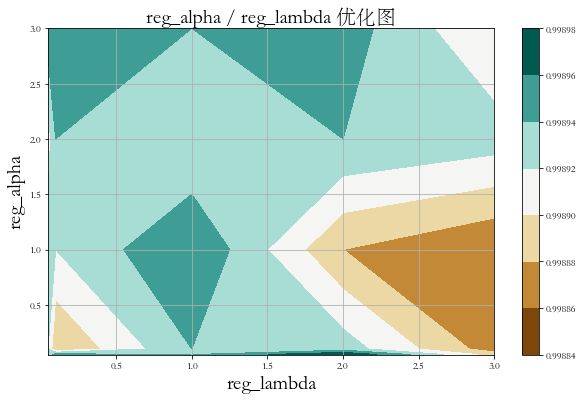

In [19]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
scores = grid_visualization.reshape(len(cv_params['reg_alpha']),len(cv_params['reg_lambda']))
plt.figure(figsize=(10,6))
cp = plt.contourf(cv_params['reg_lambda'],cv_params['reg_alpha'],scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('reg_alpha / reg_lambda 优化图',fontsize=20)
plt.xlabel('reg_lambda',fontsize=20)
plt.ylabel('reg_alpha',fontsize=20)
plt.grid(True)

In [20]:
%%time
#调参过程五：learning_rate
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:logistic'}#业务类型
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
learning_rate = optimized_GBM.best_params_['learning_rate']

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   48.8s finished


每次运行的结果如下:
 params:{'learning_rate': 0.01}  mean:0.998939989399894   std:0.0007275660350697727   rank:2
 params:{'learning_rate': 0.05}  mean:0.998929989299893   std:0.0008028328747771234   rank:3
 params:{'learning_rate': 0.07}  mean:0.998929989299893   std:0.0008028328747771234   rank:3
 params:{'learning_rate': 0.1}  mean:0.998979989799898   std:0.0007612799054712532   rank:1
 params:{'learning_rate': 0.2}  mean:0.998819988199882   std:0.0010037486020068064   rank:5
---------------------------
参数的最佳取值：{'learning_rate': 0.1}
最佳模型得分:0.998979989799898
Wall time: 51.5 s


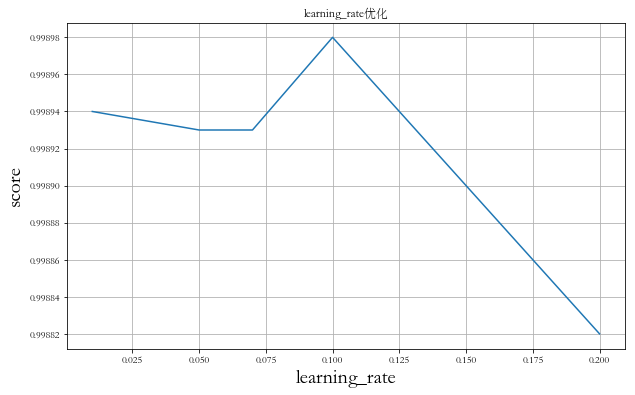

In [21]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
plt.figure(figsize=(10,6))
plt.title('learning_rate优化')
plt.xlabel('learning_rate',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot(cv_params['learning_rate'], grid_visualization)
plt.grid(True)
plt.show()

In [22]:
%%time
#调参过程五：n_estimators最佳迭代次数
cv_params = {'n_estimators':[100 * i for i in range(1,10)]}
other_params = {'learning_rate':learning_rate, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:logistic'}#业务类型
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
n_estimators = optimized_GBM.best_params_['n_estimators']

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  1.3min finished


每次运行的结果如下:
 params:{'n_estimators': 100}  mean:0.998919989199892   std:0.0007710662486201141   rank:9
 params:{'n_estimators': 200}  mean:0.998949989499895   std:0.0007674277768166852   rank:5
 params:{'n_estimators': 300}  mean:0.998959989599896   std:0.0007498984668182546   rank:2
 params:{'n_estimators': 400}  mean:0.998959989599896   std:0.0007748194890467166   rank:2
 params:{'n_estimators': 500}  mean:0.998979989799898   std:0.0007612799054712532   rank:1
 params:{'n_estimators': 600}  mean:0.998939989399894   std:0.0008101484313382552   rank:7
 params:{'n_estimators': 700}  mean:0.998949989499895   std:0.0008142112949113462   rank:5
 params:{'n_estimators': 800}  mean:0.998929989299893   std:0.00082797224283155   rank:8
 params:{'n_estimators': 900}  mean:0.998959989599896   std:0.0008217906915639322   rank:2
---------------------------
参数的最佳取值：{'n_estimators': 500}
最佳模型得分:0.998979989799898
Wall time: 1min 20s


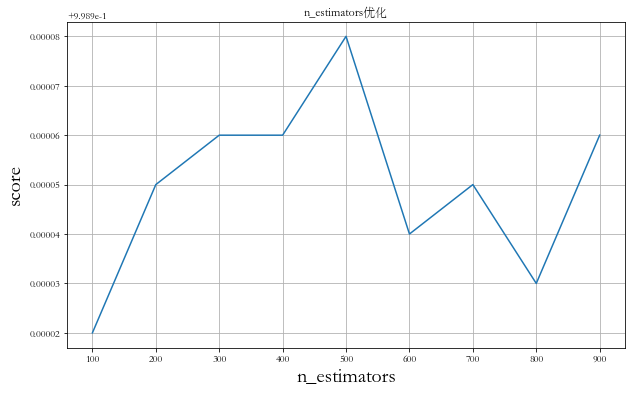

In [23]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
plt.figure(figsize=(10,6))
plt.title('n_estimators优化')
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot(cv_params['n_estimators'], grid_visualization)
plt.grid(True)
plt.show()

In [24]:
# XGBoost训练过程，下面的参数就是刚才调试出来的最佳参数组合
print("最佳learning_rate:"+str(learning_rate))
print("最佳n_estimators:"+str(n_estimators))
print("最佳max_depth:"+str(max_depth))
print("最佳min_child_weight:"+str(min_child_weight))
print("最佳subsample:"+str(subsample))
print("最佳colsample_bytree:"+str(colsample_bytree))
print("最佳gamma:"+str(gamma))
print("最佳reg_alpha:"+str(reg_alpha))
print("最佳reg_lambda:"+str(reg_lambda))
model = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight, seed=0,
                         subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                         objective='reg:logistic')#业务类型)
model.fit(train_x, train_y.values)
model.get_booster().save_model('model/xgbc.model')
print("模型保存完毕！！！")

最佳learning_rate:0.1
最佳n_estimators:500
最佳max_depth:5
最佳min_child_weight:1
最佳subsample:0.6000000000000001
最佳colsample_bytree:0.6000000000000001
最佳gamma:0.0
最佳reg_alpha:0.05
最佳reg_lambda:2
模型保存完毕！！！


Text(0, 0.5, '特征重要性评分')

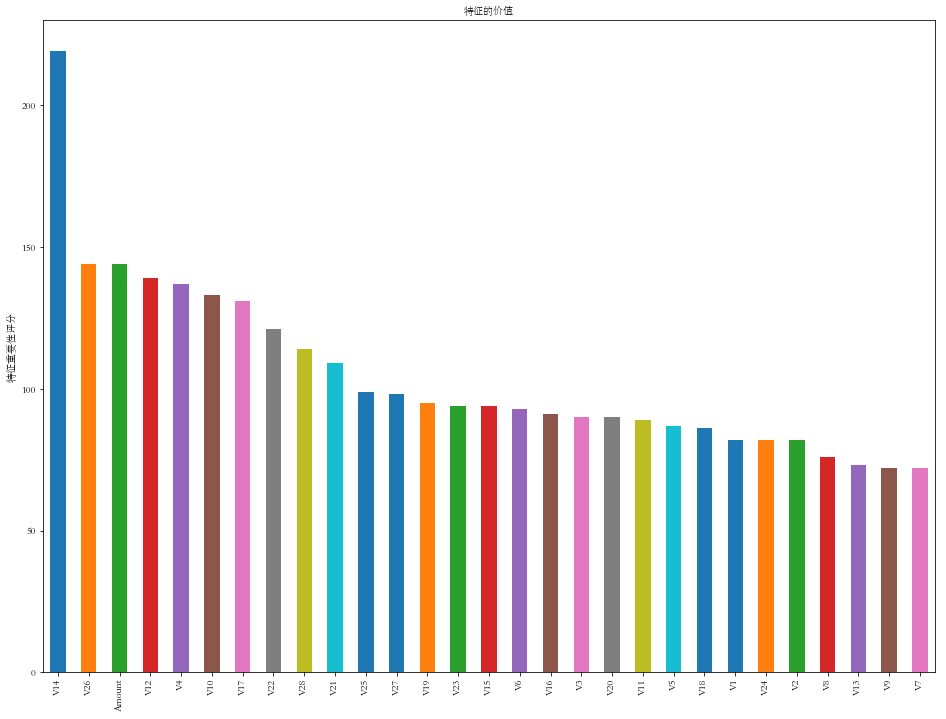

In [32]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)  
feat_imp.plot(kind='bar',figsize=(16,12),fontsize=10)  
plt.title('特征的价值',{'size': 10})
plt.ylabel('特征重要性评分',{'size': 10})  

# 加载预测并查看指标

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
#加载测试数据
test = pd.read_csv('data/card_test.csv')
model_load = xgb.Booster(model_file="model/xgbc.model")

In [27]:
#提取特征
all_features = [x for x in test.columns if x not in [test.columns[0],test.columns[-1]]]
cat_features = list(test.select_dtypes(include=['object']).columns)
#划分自变量和因变量
test_x = test[all_features]
#将离散数据转换成哑变量
for i in range(len(cat_features)):
    test_x[cat_features[i]] = test_x[cat_features[i]].astype('category').cat.codes

In [28]:
test_x = xgb.DMatrix(test_x)
result_list = model_load.predict(test_x)

In [29]:
y_pred = model_load.predict(test_x).tolist()
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_true = test['Class'].tolist()

In [30]:
import sklearn.metrics as metrics
print("准确率："+ '%.2f' % (metrics.accuracy_score(y_true,y_pred)*100)+"%")
print("精准度："+ '%.2f' % (metrics.precision_score(y_true,y_pred)*100)+"%")
print("召回率："+ '%.2f' % (metrics.recall_score(y_true,y_pred)*100)+"%")
print("综合评价："+ '%.2f' % (metrics.f1_score(y_true,y_pred)*100)+"%")
print("AUC面积："+ '%.4f' % metrics.roc_auc_score(y_true,y_pred))

准确率：99.94%
精准度：79.68%
召回率：74.35%
综合评价：76.92%
AUC面积：0.8716


<Figure size 432x288 with 0 Axes>

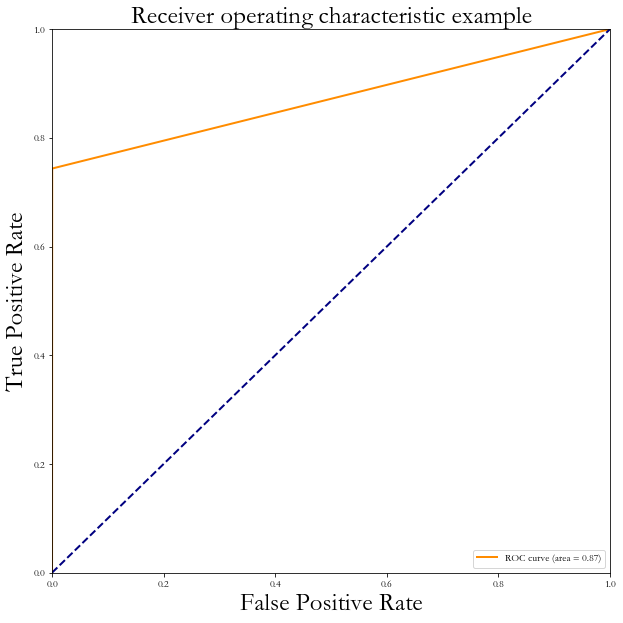

In [31]:
fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) ###计算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',{'size': 25})
plt.ylabel('True Positive Rate',{'size': 25})
plt.title('Receiver operating characteristic example',{'size': 25})
plt.legend(loc="lower right")
plt.show()